In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
☆*°☆*°(∩^o^)~━━  2017/12/3 16:14        
      (ˉ▽￣～) ~~ 一捆好葱 (*˙︶˙*)☆*°
      Fuction：机器学习lab2(py2.7代码 不兼容3的地方已注释√ ━━━━━☆*°☆*°
"""
from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
mt_cur = 0.0
mt_pre = 0.0
vt_cur = 0.0
vt_pre = 0.0

vt_curr = np.array([0.0 for i in range(124)])
vt_prev = np.array([0.0 for i in range(124)])

def get_train_data():
	data = load_svmlight_file("9a9_train")
	return data[0], data[1]

def get_test_data():
	data = load_svmlight_file("9a9_test")
	return data[0], data[1]

def Loss(X, w, y):
	X_size = X.shape[0]
	return (w ** 2).sum() + sum([max(0, 1 - y[i] * f(X[i], w)) for i in range(X_size)])

def SGD_change(X_train, y_train, w):
	X_size = X_train.shape[0]
	# 随机梯度下降更新权重w，随机选取1/2样本里的某个样本作为选择起点
	t = random.randint(0, (X_size - 1) // 2)
	# print w
	gradient_sums = np.array([0.0 for i in range(124)])
	n = 0
	# for i in range(124):
	# 	gradient_sums[i] += w[i] + sum(
	# 		[((y_train[k] * f(X_train[i], w) < 1) * (-y_train[k]) * X_train[k, i]) for k in range(t, t + (X_size - 1) // 4)])
	for k in range(t, t + (X_size - 1) // 8):
		xx = X_train[k].tolist()
		xx = np.array(list(*xx))
		gradient_sums += ((y_train[k] * f(X_train[k], w) < 1) * (-y_train[k]) * xx)
		n += 1
	return gradient_sums / n

# RMSprop学习参数更新，此函数包含SGD更新的梯度和a，即返回值为更新量
def RMSprop_change(X_train, y_train, w, a):
	global vt_cur, vt_pre
	sgd_change = SGD_change(X_train, y_train, w)
	vt_cur = vt_pre * 0.9 + 0.1 * sgd_change ** 2
	vt_pre = vt_cur
	return a * sgd_change/(np.sqrt(vt_cur) + 10 ** (-8))

# Nesterov accelerated gradient学习参数更新，此函数包含SGD更新的梯度和a，即返回值为更新量
def NAG(X_train, y_train, w, a):
	global vt_curr, vt_prev
	vt_curr = 0.9 * vt_prev + SGD_change(X_train, y_train, w - a * 0.1 * vt_prev)
	vt_prev = vt_curr
	return a * vt_curr


# Adam学习参数更新，此函数包含SGD更新的梯度和a，即返回值为更新量
def Adam_change(X_train, y_train, w, a):
	global mt_cur, mt_pre, vt_cur, vt_pre
	sgd_change = SGD_change(X_train, y_train, w)
	mt_cur = mt_pre * 0.9 + 0.1 * sgd_change
	vt_cur = vt_pre * 0.99 + 0.01 * sgd_change ** 2
	mt_pre = mt_cur
	vt_pre = vt_cur
	return mt_cur/(np.sqrt(vt_cur) + 10 ** (-8)) * a * sgd_change

# f为假设函数，即目标函数,用于分类,当 f > 0,y = +1 当 f < 0,y = -1 当 f = 0, 该点在分类超平面上
def f(x, w):
	return (x.T * w).sum()

def cal_accuracy(w, X_val, y_val):
	right_num = 0
	for i in range(X_val.shape[0]):
		result = f(X_val[i], w)
		# print result
		if result >= 0 and y_val[i] == 1 or result < 0 and y_val[i] == -1:
			right_num += 1
	return float(right_num) / float(X_val.shape[0])

def SVM(options):
	X_train, y_train = get_train_data()
	X_val, y_val = get_test_data()
	x0 = np.array([1 for i in range(X_train.shape[0])])
	# 转换为稠密矩阵
	X_train = X_train.todense()
	X_train = np.column_stack((x0, X_train))

	x0 = np.array([1 for i in range(X_val.shape[0])])
	# 转换为稠密矩阵
	X_val = X_val.todense()
	X_val = np.column_stack((x0, X_val))
	# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
	# 初始化参数的三种方式，共有13个属性，即13个系数
	# b = 0
	w = np.array([0.0 for i in range(124)])
	# w_sum = sum(w)
	# w = [w[i]/w_sum for i in range(14)]
	# print w
	# loss函数为 1/(2*n) * sum([(h(X[i])-y[i])**2 for i in range(n)]) n为向量维度
	# w[i] = w[i] - a * 1/n * sum([(h(X[i])-y[i]) for i in range(n)]) a为学习系数 0.0001 0.0016 0.03
	# a = 0.16
	# 学习步长为aa
	aa = 0.00096
	# loss = (w ** 2).sum() + 1.0 / X_size * sum([max(0, 1 - y_train[i] * f(X_train[i], w)) for i in range(X_size)])
	loss = Loss(X_train, w, y_train)
	cnt = 0
	train_loss = []
	val_loss = []
	while True:
		# 对w各分量wi进行下降
		if options == 1:
			w -= SGD_change(X_train, y_train, w) * aa
		elif options == 2:
			w -= Adam_change(X_train, y_train, w, aa)
		elif options == 3:
			w -= RMSprop_change(X_train, y_train, w, aa)
		else:
			w -= NAG(X_train, y_train, w, aa)
		# print cal_accuracy(w, b, X_train, y_train)
		new_loss = Loss(X_train, w, y_train)
		v_loss = Loss(X_val, w, y_val)
		if abs(loss - new_loss) > 0.00001:
			loss = new_loss
			print ("Train_loss: " + str(loss))
			print ('Test_loss: ' + str(v_loss))
		else:
			break
		train_loss.append(loss)
		val_loss.append(v_loss)
		cnt += 1
		if cnt > 35:
			break
	plt.figure(figsize=(8,6))
	plt.xlabel('Gradient descent - Iteration times')
	plt.ylabel('Loss')
	plt.plot(range(cnt), train_loss, 'o-', label=u"Training Set")
	plt.plot(range(cnt), val_loss, 'r-', label=u"Validation set")
	plt.legend()
	plt.grid()
	plt.show()

Train_loss: 30634.0267463
Test_loss: 1546.02096381
Train_loss: 28760.7099227
Test_loss: 1452.71446074
Train_loss: 26956.2620101
Test_loss: 1362.83819642
Train_loss: 25118.3820205
Test_loss: 1271.29674485
Train_loss: 23251.9049288
Test_loss: 1178.33092746
Train_loss: 21344.5074462
Test_loss: 1083.3269439
Train_loss: 19507.8656936
Test_loss: 991.847177756
Train_loss: 17636.9663809
Test_loss: 898.661108906
Train_loss: 15949.4066696
Test_loss: 814.657452731
Train_loss: 16385.6513772
Test_loss: 836.335404371
Train_loss: 16385.7866867
Test_loss: 836.737034822
Train_loss: 16122.7297506
Test_loss: 823.453761794
Train_loss: 15929.3359177
Test_loss: 813.607174343
Train_loss: 16573.8912681
Test_loss: 846.080872405
Train_loss: 16308.6600738
Test_loss: 832.889901289
Train_loss: 16061.6852898
Test_loss: 820.355710516
Train_loss: 16090.0103889
Test_loss: 821.610085858
Train_loss: 16528.9367479
Test_loss: 843.847831192
Train_loss: 16270.6052889
Test_loss: 830.958598345
Train_loss: 16040.4330967
Test_l

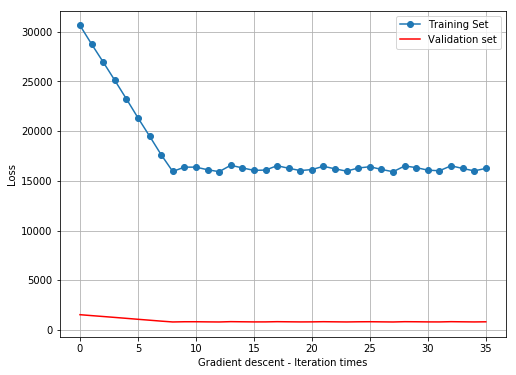

In [4]:
SVM(1)  # SGD

Train_loss: 30629.2534943
Test_loss: 1545.78321678
Train_loss: 28053.3782376
Test_loss: 1417.48355698
Train_loss: 24984.6467205
Test_loss: 1264.63563267
Train_loss: 21749.4019665
Test_loss: 1103.49399832
Train_loss: 18308.4279815
Test_loss: 932.1053787
Train_loss: 16338.0874461
Test_loss: 834.36763552
Train_loss: 16073.7725198
Test_loss: 820.969126023
Train_loss: 15940.853087
Test_loss: 814.223340783
Train_loss: 15949.4384373
Test_loss: 814.608420901
Train_loss: 16744.7291345
Test_loss: 854.56697748
Train_loss: 16690.0925319
Test_loss: 851.852975867
Train_loss: 16696.892833
Test_loss: 852.190765384
Train_loss: 16760.0102674
Test_loss: 855.326029595
Train_loss: 16880.0806975
Test_loss: 861.332708476
Train_loss: 17045.4656494
Test_loss: 869.776742326
Train_loss: 17267.2252994
Test_loss: 881.099092723
Train_loss: 17542.210906
Test_loss: 895.138994848
Train_loss: 17855.6355019
Test_loss: 911.110495563
Train_loss: 18210.2361975
Test_loss: 929.172620212
Train_loss: 18590.4915002
Test_loss: 9

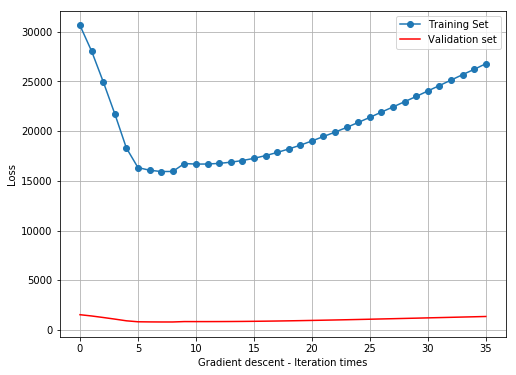

In [8]:
SVM(2)  # Adam

Train_loss: 33216.5368552
Test_loss: 1693.84142512
Train_loss: 22264.1289612
Test_loss: 1135.66382122
Train_loss: 24351.9153728
Test_loss: 1233.12083758
Train_loss: 33734.7479413
Test_loss: 1720.26451257
Train_loss: 24305.7799591
Test_loss: 1239.6592089
Train_loss: 16931.7826401
Test_loss: 863.538475354
Train_loss: 35233.0124796
Test_loss: 1796.65884366
Train_loss: 26321.6743389
Test_loss: 1342.34316714
Train_loss: 17706.3234495
Test_loss: 903.507800547
Train_loss: 28555.7221351
Test_loss: 1442.50769419
Train_loss: 28625.6874668
Test_loss: 1459.76819109
Train_loss: 20746.571098
Test_loss: 1058.36901843
Train_loss: 21215.8203657
Test_loss: 1076.92226057
Train_loss: 31962.9842892
Test_loss: 1629.93131741
Train_loss: 24258.0154071
Test_loss: 1237.23169488
Train_loss: 16489.3748792
Test_loss: 841.889684261
Train_loss: 27150.2801122
Test_loss: 1372.50978639
Train_loss: 28826.3351946
Test_loss: 1470.00374564
Train_loss: 21665.842761
Test_loss: 1105.19868928
Train_loss: 17947.4164885
Test_los

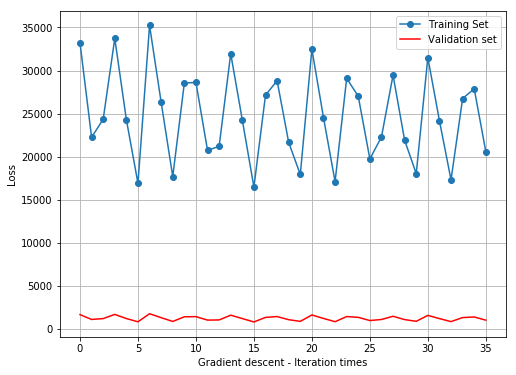

In [9]:
SVM(3) # RMSprop

Train_loss: 30711.6221932
Test_loss: 1549.88585197
Train_loss: 27187.6037537
Test_loss: 1374.36090723
Train_loss: 22113.3656975
Test_loss: 1121.62236821
Train_loss: 15972.7865327
Test_loss: 815.844001946
Train_loss: 18154.9449325
Test_loss: 926.356345303
Train_loss: 19934.3014002
Test_loss: 1016.99061187
Train_loss: 21135.4055023
Test_loss: 1078.1707205
Train_loss: 21821.9926288
Test_loss: 1113.14312274
Train_loss: 22043.8574194
Test_loss: 1124.44418122
Train_loss: 21837.4745457
Test_loss: 1113.93178898
Train_loss: 21248.651474
Test_loss: 1083.93922133
Train_loss: 20325.1326737
Test_loss: 1036.89841957
Train_loss: 19094.4499445
Test_loss: 974.211762632
Train_loss: 17579.6583129
Test_loss: 897.051361515
Train_loss: 16018.0463176
Test_loss: 818.141419947
Train_loss: 17040.1253132
Test_loss: 868.934084732
Train_loss: 16500.2019853
Test_loss: 842.041600232
Train_loss: 16525.1789333
Test_loss: 843.661911485
Train_loss: 17104.9784434
Test_loss: 872.816223493
Train_loss: 17298.6571035
Test_lo

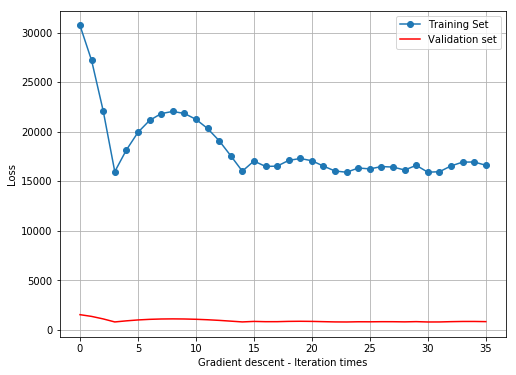

In [10]:
SVM(4) # NAG